Decay Rate 30: Step 700000 Epsilon = 0.052354
Decay Rate 60: Step 700000 Epsilon = 0.221760
Decay Rate 90: Step 700000 Epsilon = 0.359951
Decay Rate 120: Step 700000 Epsilon = 0.458713
Decay Rate 90: Step 700000 Epsilon = 0.359951
Decay Rate 120: Step 700000 Epsilon = 0.458713
Decay Rate 200: Step 700000 Epsilon = 0.613720
Decay Rate 200: Step 700000 Epsilon = 0.613720


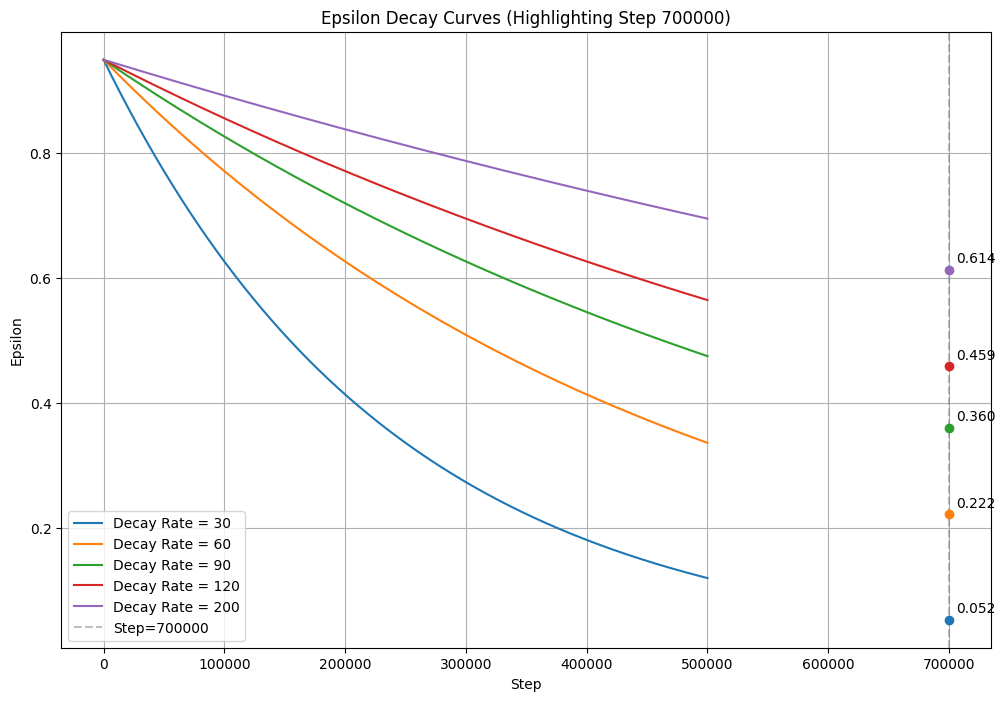

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import math

MAX_EPSILON = 0.95      # Maximum value that the exploration parameter can have
MIN_EPSILON = 0.001     # Minimum value that the exploration parameter can have
LAMBDA      = 0.0005   # This value is used to decay the epsilon in the deep learning implementation

# List of decay rates to compare
decay_rates = [30, 60, 90, 120, 200]

# Target step to inspect (e.g., 100,000)
target_step = 700000

# Generate steps for visualization
# Adjust the range (0 to 500000) to match your expected simulation duration
steps_range = np.linspace(0, 500000, 500000)

plt.figure(figsize=(12, 8))

for rate in decay_rates:
    # Calculate epsilon values for each step with the current decay rate
    epsilon_values = [MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * step / (rate * (2**2))) for step in steps_range]
    
    # Calculate value at target step specifically
    val_at_target = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * target_step / (rate * (2**2)))
    
    # Plotting
    p = plt.plot(steps_range, epsilon_values, label=f'Decay Rate = {rate}')
    
    # Mark the target point on the plot
    plt.scatter([target_step], [val_at_target], color=p[0].get_color(), zorder=5)
    # Add text annotation
    plt.annotate(f'{val_at_target:.3f}', (target_step, val_at_target), xytext=(5, 5), textcoords='offset points')
    
    print(f"Decay Rate {rate}: Step {target_step} Epsilon = {val_at_target:.6f}")

plt.axvline(x=target_step, color='gray', linestyle='--', alpha=0.5, label=f'Step={target_step}')
plt.title(f'Epsilon Decay Curves (Highlighting Step {target_step})')
plt.xlabel('Step')
plt.ylabel('Epsilon')
plt.grid(True)
plt.legend()
plt.show()

In [4]:


class AdaptiveTrafficGenerator:
    def __init__(self):
        self.frequency_modes = ['low', 'medium', 'high', 'burst']
        
    def generate_request_sequence(self, mode, duration):
        if mode == 'low':
            interval = np.random.exponential(5.0)  # 平均5秒一个请求
        elif mode == 'medium':
            interval = np.random.exponential(2.0)  # 平均2秒一个请求
        elif mode == 'high':
            interval = np.random.exponential(0.5)  # 平均0.5秒一个请求
        elif mode == 'burst':
            # 突发流量：短时间内大量请求
            base_interval = np.random.exponential(1.0)
            burst_prob = 0.1  # 10%概率触发突发
            if np.random.random() < burst_prob:
                interval = 0.1  # 突发期间间隔很短
            else:
                interval = base_interval
        return interval
    

import numpy as np
import time
import random

traffic_mode = np.random.choice(['low', 'medium', 'high', 'burst'])
traffic_generator = AdaptiveTrafficGenerator()

a = traffic_generator.generate_request_sequence(traffic_mode, duration=60)
print(f"Generated request interval for mode '{traffic_mode}': {a:.2f} seconds")




Generated request interval for mode 'low': 3.12 seconds


In [9]:
import dgl
import networkx as nx
import torch

# 1. 创建带属性的 NetworkX 图
# 【关键】使用 nx.Graph() 表示无向图
nx_g = nx.Graph() 

# 添加节点及其属性 'feat' (特征) 和 'label' (标签)
nx_g.add_node(0, feat=[1.0, 1.0], label=0)
nx_g.add_node(1, feat=[2.0, 2.0], label=1)
nx_g.add_node(2, feat=[3.0, 3.0], label=0)

# 添加边及其属性 'weight'
nx_g.add_edge(0, 1, weight=0.5)
nx_g.add_edge(1, 2, weight=1.5)
nx_g.add_edge(2, 0, weight=2.5)

# 2. 转换为 DGL 图
# 【修复】对于无向图，不能直接使用 edge_attrs 参数
# 因为 DGL 无法确定如何将一条无向边的属性分配给两条有向边
# 必须先转换图结构，然后再手动赋值边属性
g = dgl.from_networkx(nx_g, node_attrs=['feat', 'label'])

# 3. 手动处理边属性
# 由于 DGL 将无向边 (u, v) 拆分为 (u->v) 和 (v->u)
# 我们需要构建一个与 DGL 边顺序对应的权重张量

# 获取原图的边数据
src, dst = g.edges()
weights = []

# 打印具体的边连接情况
print("DGL 边连接详情 (源 -> 目标):")
for u, v in zip(src, dst):
    print(f"  {u.item()} -> {v.item()}")

# 遍历 DGL 的每一条边，去原图中查找对应的权重
for u, v in zip(src, dst):
    # NetworkX 的无向图边访问是无序的，(u, v) 和 (v, u) 是一样的
    # 使用 nx_g[u_id][v_id]['weight'] 可以安全获取
    w = nx_g[u.item()][v.item()]['weight']
    weights.append(w)

# 将权重赋值给 DGL 图
g.edata['weight'] = torch.tensor(weights)

# 4. 验证结果
print(f"原 NetworkX (无向) 边数: {nx_g.number_of_edges()}")
print(f"DGL (双向) 边数: {g.num_edges()}") 
print("提示: DGL 边数是原图的2倍是正常的，这代表了双向连接。\n")

# 打印具体的边连接情况
print("DGL 边连接详情 (源 -> 目标):")
for u, v, w in zip(src, dst, g.edata['weight']):
    print(f"  {u.item()} -> {v.item()} (权重: {w.item()})")

DGL 边连接详情 (源 -> 目标):
  0 -> 1
  0 -> 2
  1 -> 0
  1 -> 2
  2 -> 0
  2 -> 1
原 NetworkX (无向) 边数: 3
DGL (双向) 边数: 6
提示: DGL 边数是原图的2倍是正常的，这代表了双向连接。

DGL 边连接详情 (源 -> 目标):
  0 -> 1 (权重: 0.5)
  0 -> 2 (权重: 2.5)
  1 -> 0 (权重: 0.5)
  1 -> 2 (权重: 1.5)
  2 -> 0 (权重: 2.5)
  2 -> 1 (权重: 1.5)
